# ライブラリインポート

In [44]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling as pdp
import os
%matplotlib inline
import seaborn as sns
from tqdm.auto import tqdm
import statsmodels
import statsmodels.api as sm

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_pinball_loss
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

# データ準備

In [45]:
train_df = pd.read_csv('../work/train_preprocessed_from2021.csv')
train_df.head()

id        date  year  month  day  weekday  highest  lowest  rain  ice1  \
0   1  2021-04-11  2021      4   11        6     21.9    12.4   0.0    25   
1   2  2021-04-12  2021      4   12        0     25.9    13.9   0.0    30   
2   3  2021-04-13  2021      4   13        1     20.9    11.9   0.0    21   
3   4  2021-04-14  2021      4   14        2     18.8    11.4   0.0    19   
4   5  2021-04-15  2021      4   15        3     22.1    13.5  19.0    21   

   ...  bento3  bento4  tild1  tild2  men1  men2  men3  men4  men5  men6  
0  ...      70      27     12     12    57    30    41    38    37    35  
1  ...      23       9      5      8    19     9    13    26     4    16  
2  ...      19       6      4      9    23     9    11    33     4    13  
3  ...      74      28     15     17    55    35    46    46    51    46  
4  ...      69      26      4      9    54    33    39    40    41    40  

[5 rows x 48 columns]

In [63]:
# 日付以外のデータ
num_col = ['highest', 'lowest', 'rain',
       'ice1', 'ice2', 'ice3', 'oden1', 'oden2', 'oden3', 'oden4', 'hot1',
       'hot2', 'hot3', 'dessert1', 'dessert2', 'dessert3', 'dessert4',
       'dessert5', 'drink1', 'drink2', 'drink3', 'drink4', 'drink5', 'drink6',
       'alcol1', 'alcol2', 'alcol3', 'snack1', 'snack2', 'snack3', 'bento1',
       'bento2', 'bento3', 'bento4', 'tild1', 'tild2', 'men1', 'men2', 'men3',
       'men4', 'men5', 'men6']

target_cols = ['ice1', 'ice2', 'ice3', 'oden1', 'oden2', 'oden3', 'oden4', 'hot1',
       'hot2', 'hot3', 'dessert1', 'dessert2', 'dessert3', 'dessert4',
       'dessert5', 'drink1', 'drink2', 'drink3', 'drink4', 'drink5', 'drink6',
       'alcol1', 'alcol2', 'alcol3', 'snack1', 'snack2', 'snack3', 'bento1',
       'bento2', 'bento3', 'bento4', 'tild1', 'tild2', 'men1', 'men2', 'men3',
       'men4', 'men5', 'men6']

# Pandas Profiling

In [ ]:
# profile = pdp.ProfileReport(train_df, title='ProbSpace competition data profile')
# profile.to_file("../work/eda/probspace_comp_data_profile.html")

# 年間の推移

In [61]:
# 背景色
plt.rcParams['axes.facecolor'] = 'bisque'

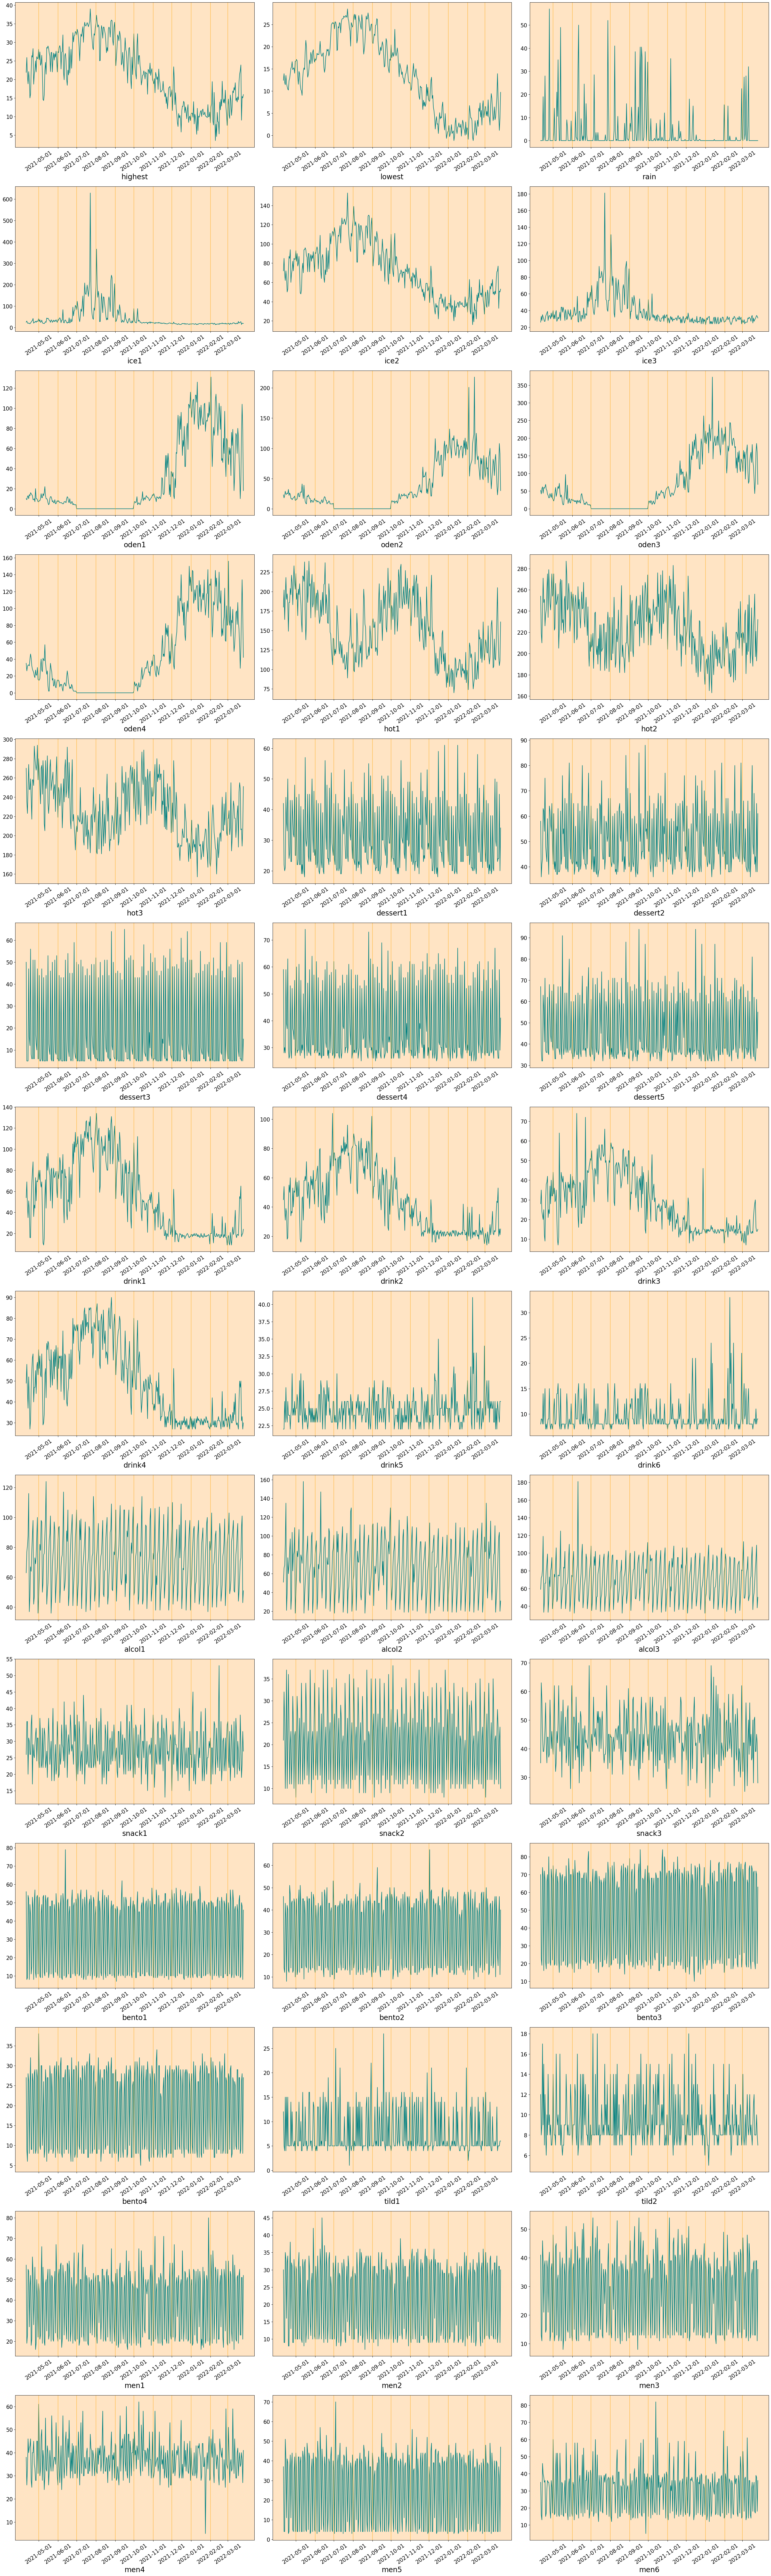

In [47]:
ncols = len(plot_col) // 13

plt.subplots(14, ncols, sharey=False, sharex=False, figsize=(30, 100))

for i, col in enumerate(num_col):
    plt.subplot(14, ncols, i+1)
    ax = plt.gca()
    plt.plot(train_df.date, train_df[col], alpha=1, color='teal', label=col)
    for x in list(train_df.date[train_df.day==1]):
        plt.axvline(x, color='orange', alpha=0.5)
    plt.xticks(list(train_df.id[train_df.day==1]-1), list(train_df.date[train_df.day==1]), rotation=35, fontsize=15)
    plt.xlabel(col, fontsize=20)
    plt.yticks(fontsize=15)
    plt.tight_layout()

plt.savefig('../work/eda/trend_per_year.png')
plt.savefig('../work/eda/trend_per_year.pdf')  
plt.show()


# 週の周期性

In [48]:
# pd.options.display.precision = 1
# train_df.groupby('weekday').mean()[plot_col].style.background_gradient() #これでもヒートマップで可視化できる

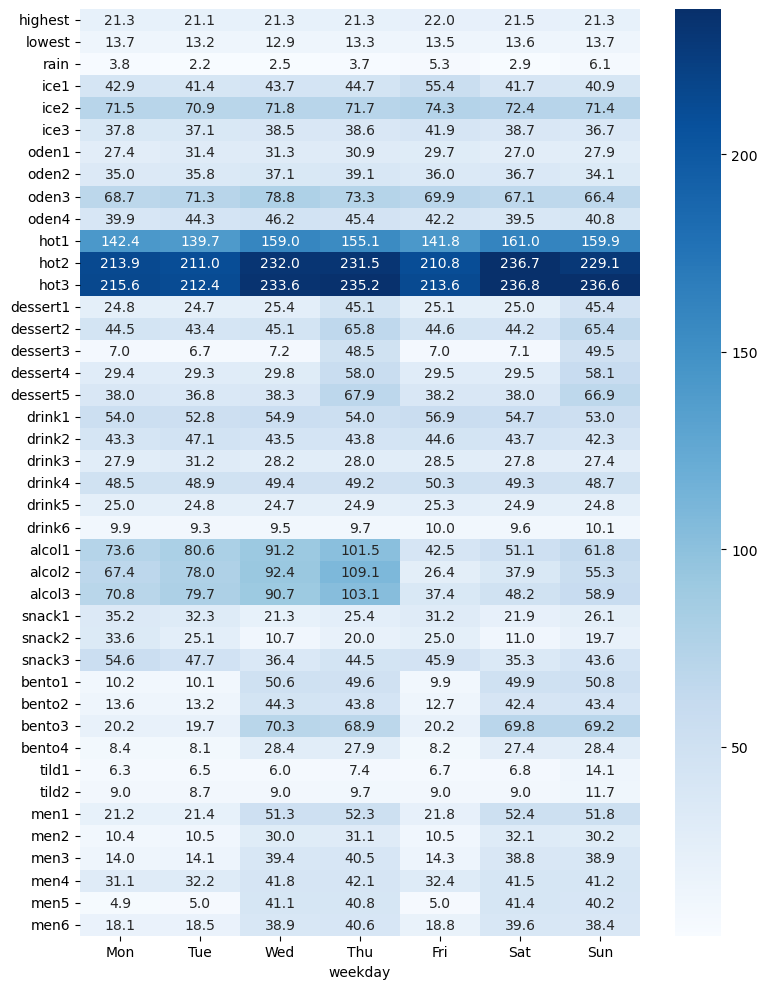

In [54]:
# 標準化してヒートマップ
plt.figure(figsize=(8, 10))
sns.heatmap(train_df.groupby('weekday').mean()[num_col].T, vmin=None, vmax=None, cmap='Blues', center=None, robust=False,
                annot=True, fmt='.1f', annot_kws=None, linewidths=0,
                linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None,
                square=False, ax=None, xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], yticklabels=True,
                mask=None)

plt.tight_layout()

plt.savefig('../work/eda/trend_per_week.png')
plt.savefig('../work/eda/trend_per_week.pdf')

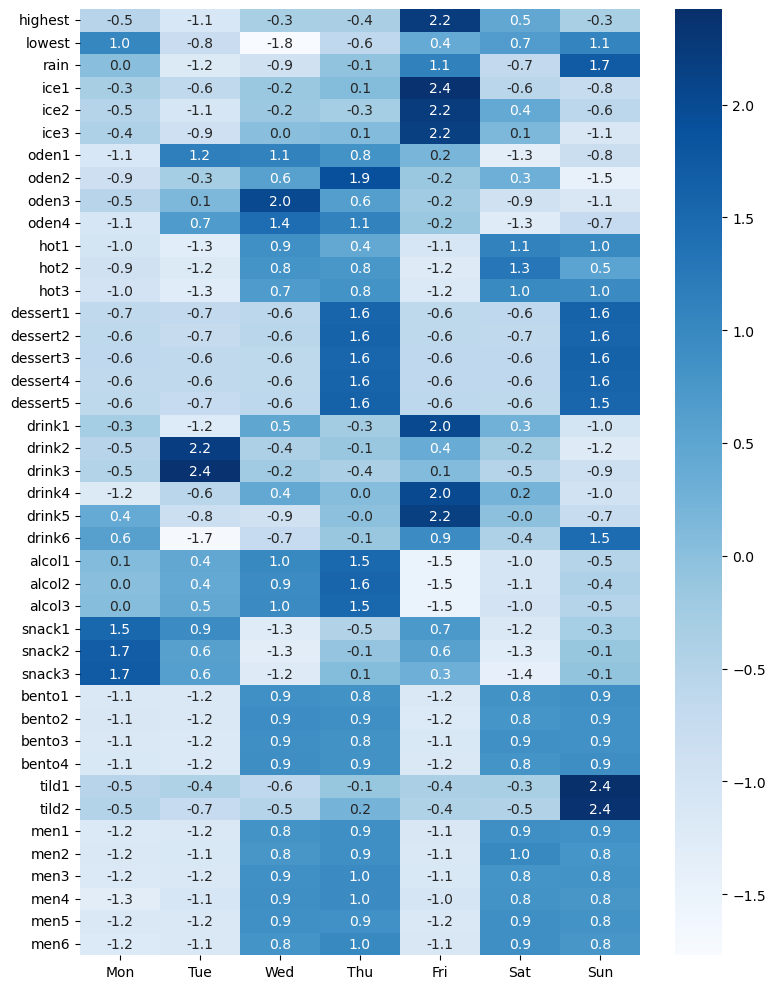

In [51]:
# 標準化してヒートマップ
scaler = StandardScaler()
scaler.fit(train_df.groupby('weekday').mean()[num_col])

train_df_std = scaler.transform(train_df.groupby('weekday').mean()[num_col])

plt.figure(figsize=(8, 10))
sns.heatmap(train_df_std.T, vmin=None, vmax=None, cmap='Blues', center=None, robust=False,
                annot=True, fmt='.1f', annot_kws=None, linewidths=0,
                linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None,
                square=False, ax=None, xticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], yticklabels=num_col,
                mask=None)
plt.tight_layout()

plt.savefig('../work/eda/trend_std_per_week.png')
plt.savefig('../work/eda/trend_std_per_week.pdf')

# 日付の周期性

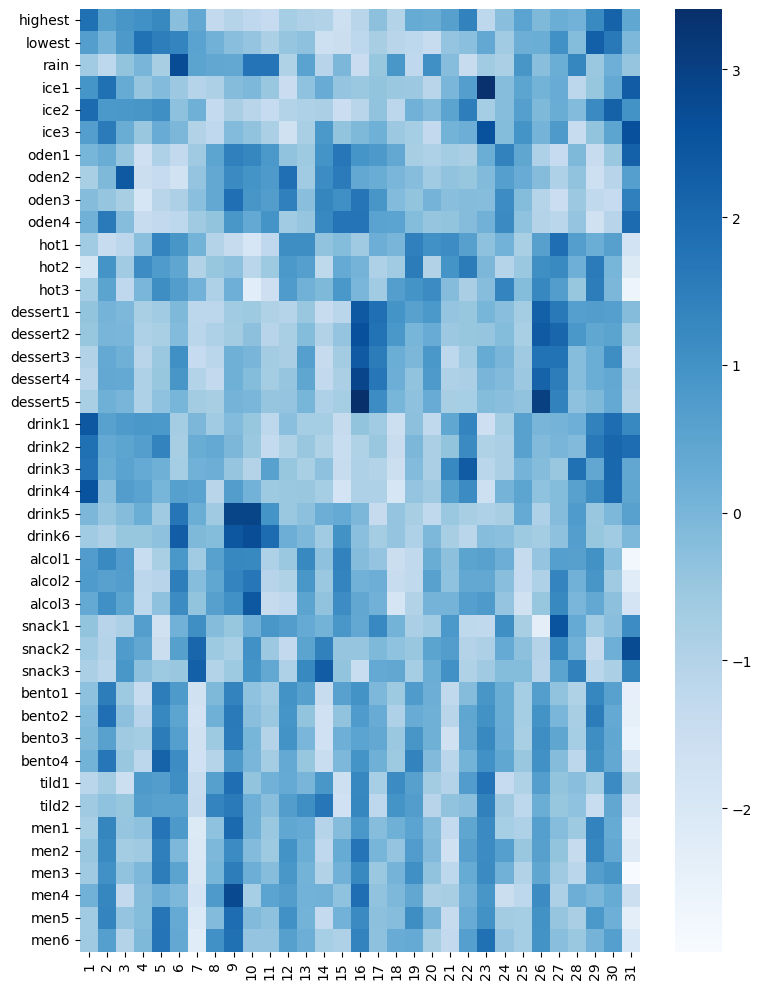

In [60]:
# 標準化してヒートマップ
scaler = StandardScaler()
scaler.fit(train_df.groupby('day').mean()[num_col])

train_df_std = scaler.transform(train_df.groupby('day').mean()[num_col])

plt.figure(figsize=(8, 10))
sns.heatmap(train_df_std.T, vmin=None, vmax=None, cmap='Blues', center=None, robust=False,
                annot=False, fmt='.1f', annot_kws=None, linewidths=0,
                linecolor='white', cbar=True, cbar_kws=None, cbar_ax=None,
                square=False, ax=None, xticklabels=list(range(1, 32)), yticklabels=num_col,
                mask=None)
plt.tight_layout()

plt.savefig('../work/eda/trend_std_per_day.png')
plt.savefig('../work/eda/trend_std_per_day.pdf')

# テストデータに似ている訓練データを探す

Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.812389
Early stopping, best iteration is:
[13]	valid_0's auc: 0.875221


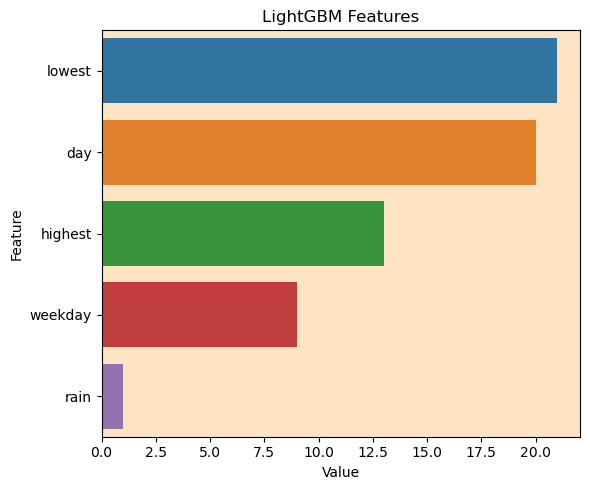

Value  Feature
0     21   lowest
1     20      day
2     13  highest
3      9  weekday
4      1     rain

[0.24336649 0.24336649 0.24336649 0.24336649 0.24336649 0.24336649
 0.24336649 0.24336649 0.24275918 0.24275918 0.24121177 0.22628032
 0.22569105 0.22569105 0.22508373 0.22292901 0.20872678 0.16938454
 0.16795426 0.16795426 0.16322509 0.16322509 0.16173036 0.15930967
 0.15930967 0.15086809 0.15086809 0.14909141 0.147544   0.147544  ]
[133 184 178 172 216 151 240  92  79 138  89  72 123 193   5  54  42  74
 119 229 162  29 171  70 209 201  69 205 152 112]


In [82]:
seed = 42
train_df = pd.read_csv('../work/preprocessed/train_preprocessed_from2021.csv')
test_df = pd.read_csv('../work/preprocessed/test_preprocessed_from2021.csv')
train_df = train_df.drop(target_cols, axis=1)

# 訓練データ: 0, テストデータ: 1
train_df['target'] = 0
test_df['target'] = 1
all_df = pd.concat([train_df, test_df], axis=0)
target = all_df['target'].values

# train: lowest, highest, rain, day, weekday
# test: 0, 1
train_, test_ = train_test_split(all_df, test_size=0.33, random_state=seed, shuffle=True)
train_X = train_.drop(['id', 'date', 'year', 'month', 'target'], axis=1)
test_X = test_.drop(['id', 'date', 'year', 'month', 'target'], axis=1)
train_y = train_['target'].values
test_y = test_['target'].values

lgb_train = lgb.Dataset(train_X, label=train_y)
lgb_test = lgb.Dataset(test_X, label=test_y)

# setting
param = {'metric': 'auc',
         'seed': seed,
         'verbosity': -1}
num_round = 100

# モデル作成
clf = lgb.train(param, lgb_train, num_round, valid_sets = [lgb_test], verbose_eval=50, early_stopping_rounds = 50)

# テストデータかどうか予測する上で重要な順に特徴量をソート
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), train_X.columns), reverse=True), columns=['Value','Feature'])

# 特徴量の重要度を棒グラフで表示
plt.figure(figsize=(6, 5))
sns.barplot(x="Value", y="Feature", data=feature_imp.head(500))
plt.title('LightGBM Features')
plt.tight_layout()
plt.savefig('../work/eda/feature_importance.png')
plt.show()

# 訓練データとテストデータが大きく似ている部分はなさそう
display(feature_imp)
print(np.sort(clf.predict(train_X))[::-1][:30])
print(np.argsort(clf.predict(train_X))[::-1][:30])